## Pipeline

In [26]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, average_precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Custom transformer for cyclical encoding
from sklearn.base import BaseEstimator, TransformerMixin

In [19]:
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, periods):
        self.columns = columns
        self.periods = periods

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, period in zip(self.columns, self.periods):
            X_copy[f'{col}_sin'] = np.sin(2 * np.pi * X_copy[col] / period)
            X_copy[f'{col}_cos'] = np.cos(2 * np.pi * X_copy[col] / period)
            X_copy = X_copy.drop(col, axis=1)
        return X_copy

In [27]:
# 📌Load transformed data
X_train = pd.read_csv("../data/processed/x_train_final.csv")
y_train = pd.read_csv("../data/processed/y_train_final.csv").values.ravel()
X_test = pd.read_csv("../data/processed/X_test_final.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (219136, 220) (219136,)
Test shape: (30223, 225) (30223,)


In [28]:
# 💡 Ensure column alignment
X_test = X_test[X_train.columns]  # 🚨 This line fixes the feature mismatch error

In [30]:
# Full pipeline with SMOTENC and RandomForest
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

In [31]:
# Train pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [32]:
# Evaluate on test set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [33]:
# Print evaluation metrics
print("📊 Random Forest Evaluation")
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC-PR:", average_precision_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

📊 Random Forest Evaluation
F1 Score: 0.546031746031746
AUC-PR: 0.6169511053042231
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     27393
           1       0.55      0.55      0.55      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.75      0.75     30223
weighted avg       0.91      0.91      0.91     30223



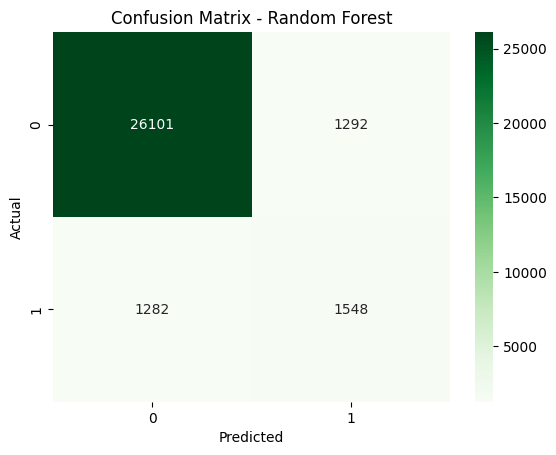

In [34]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../figures/confusion_matrix_rf.png")
plt.show()

In [36]:
# Save pipeline
joblib.dump(pipeline, "../models/fraud_rf_pipeline.joblib")

# Save feature names for FastAPI input validation
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, "../models/feature_names.joblib")

['../models/feature_names.joblib']